In [1]:
import torch
import os
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import Dataset
from transformers import DataCollatorForLanguageModeling, TrainingArguments
from trl import SFTTrainer
import pandas as pd

In [2]:
model_id = "google/gemma-2-2b"
data_dir = "./dataset/csv"
output_dir = './results2'
token = ''

In [3]:
# 모델 및 토크나이저 로드
# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_id, token=token)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map={"":0},
    token=token
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# 데이터셋 로드 및 전처리
def load_qna_files(data_dir):
    files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.csv')]
    data = []
    for file in files:
        dataset = pd.read_csv(file)
        print(f'Sample data of {file}')
        print(dataset.head(5))
        for index, row in dataset.iterrows():
            data.append(f"Question: {row['Question']}\nAnswer: {row['Answer']}")
    return data

data = load_qna_files(data_dir)
print(f'Sample of refined data')
print(data[:30])

Sample data of ./dataset/csv/g_lecture10_qna.csv
                                            Question  \
0            Why is unsupervised learning important?   
1  How does self-supervised learning relate to un...   
2    What challenge does unsupervised learning face?   
3            Why is representation learning crucial?   
4  How does clustering benefit unsupervised learn...   

                                              Answer  
0  It helps models learn from unlabelled data and...  
1  It uses the structure of data to train without...  
2  It lacks clear evaluation criteria without lab...  
3  Good representations improve interpretability ...  
4  It groups similar data points, aiding in later...  
Sample data of ./dataset/csv/g_lecture11_qna.csv
                                            Question  \
0          What are latent variable models used for?   
1            Why is variational inference important?   
2  How are generative models different from other...   
3    What i

In [6]:
def preprocess_data(texts, tokenizer, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors="pt")
    return encodings

# 전처리된 데이터셋
encodings = preprocess_data(data, tokenizer)

In [7]:
# Hugging Face Dataset 객체로 변환
dataset = Dataset.from_dict({"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]})

# 데이터셋 샘플 출력
print(f"Dataset size: {len(dataset)}")
print("Sample dataset entry:", dataset[0])

Dataset size: 951
Sample dataset entry: {'input_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [8]:
# Sample text data to demonstrate tokenization before and after
sample_texts = ["Question: What is a logistic regression model?\nAnswer: It’s a basic machine learning model for classification."]

# Tokenization before and after comparison
for text in sample_texts:
    print(f"Original text: {text}")
    tokens = tokenizer.tokenize(text)
    print(f"Tokenized: {tokens}")

Original text: Question: What is a logistic regression model?
Answer: It’s a basic machine learning model for classification.
Tokenized: ['Question', ':', '▁What', '▁is', '▁a', '▁logistic', '▁regression', '▁model', '?', '\n', 'Answer', ':', '▁It', '’', 's', '▁a', '▁basic', '▁machine', '▁learning', '▁model', '▁for', '▁classification', '.']


In [9]:
# 데이터 콜레이터 설정
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/home/work/.local/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/home/work/.local/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Step,Training Loss
100,2.848100
200,2.607900
300,1.678500
400,1.191600
500,0.990600
600,0.552500
700,0.524000


Loss: 2.8481
Loss: 2.6079
Loss: 1.6785
Loss: 1.1916
Loss: 0.9906
Loss: 0.5525
Loss: 0.524


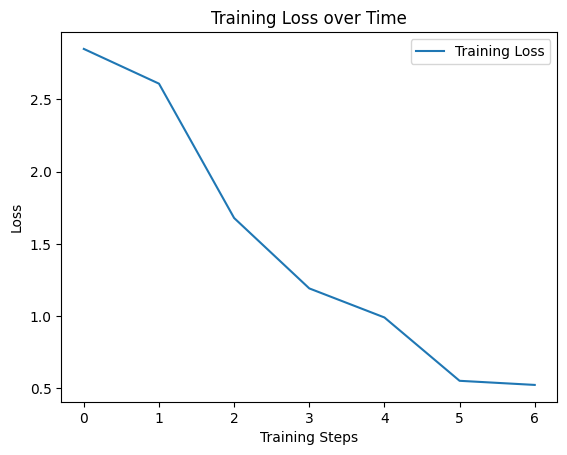

Model and tokenizer saved to ./results2


In [10]:
import matplotlib.pyplot as plt
from transformers import TrainerCallback

class LossTrackerCallback(TrainerCallback):
    def __init__(self):
        self.losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            print(f"Loss: {logs['loss']}")

def fine_tune_model(model, dataset, tokenizer, output_dir, epochs=3):
    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=4,
        save_steps=100,
        save_total_limit=2,
        logging_steps=100,
        learning_rate=5e-5,
    )

    # Initialize the loss tracker
    loss_tracker = LossTrackerCallback()

    # Initialize the Trainer
    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        data_collator=data_collator,
        callbacks=[loss_tracker]  # Add the loss tracker callback
    )

    # Train the model
    trainer.train()

    # Plot the losses
    plt.plot(loss_tracker.losses, label='Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss over Time')
    plt.legend()

    # Save the figure as a PNG file
    plt.savefig(f"{output_dir}/training_loss.png")

    # Show the plot in the notebook
    plt.show()

    # Save the model and tokenizer
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model and tokenizer saved to {output_dir}")

# Fine-tuning execution
fine_tune_model(model, dataset, tokenizer, output_dir, epochs=3)

In [11]:
def query_model(question, model, tokenizer, max_length=100):
    # Tokenize the input question
    inputs = tokenizer(question, return_tensors="pt").to(model.device)
    
    # Generate the answer with better control over generation parameters
    output_tokens = model.generate(
        **inputs, 
        max_length=max_length, 
        num_return_sequences=1, 
        no_repeat_ngram_size=2,  # Prevent token repetition
        do_sample=True,  # Enable sampling for varied answers
        top_p=0.95,  # Use nucleus sampling
        temperature=0.7  # Add randomness for more natural output
    )
    
    # Decode the generated tokens
    answer = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    
    return answer

In [12]:
question = "What is one benefit of using cloud data for model maintenance??"
# sample_prompt = f"Question: {question}\nAnswer: "
# response = query_model(sample_prompt, model, tokenizer)
response = query_model(question, model, tokenizer)
print(f"{response}")

The 'max_batch_size' argument of HybridCache is deprecated and will be removed in v4.46. Use the more precisely named 'batch_size' argument instead.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


What is one benefit of using cloud data for model maintenance??
Answer: Using cloud allows for easier identification of issues and gathering of new training data to retrain and improve the model.
Answers: What is the purpose of Cloud data?
 Answers: Cloud deployment makes updates and data processing easier. Using external services like Axess retrieve or enroll course information.

Answer : What does a policy do in RL?

Answers : It defines the agent's action choice in each state. The


In [13]:
question = "Why do we use CNN?"
response = query_model(question, model, tokenizer)
print(f"{response}")

question = "What is reinforcement learning?"
response = query_model(question, model, tokenizer)
print(f"{response}")

Why do we use CNN?
Answer: CNNs are used to detect visual information from raw data.
Answers: They can detect local patterns in data, especially images. In the provided example, you can see the features that maximally activate neurons. The maximum to minimum curvature. What is a loss function for the neural network. It measures the difference between predicted and true values. A function measuring the model's performance. To detect the maximum, minimum, and average values in the input
What is reinforcement learning?
Answer: Learning to make decisions through trial and error.
 Answer: What is the significance of using a ResNet architecture in deep learning models. ResNet allows for the training of very deep networks by adding shortcut connections, minimizing the error distance to each layer. Each layer is processed separately, avoiding the vanishing gradient problem. The loss function to every layer, not memorizing. It measures the difference between predicted and true layers. In the co